In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ielts-writing-dataset10/ielts_writing_dataset.csv


# install dependencies

In [2]:
!pip install transformers tensorflow

In [3]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# load the dataset


In [6]:
# Load your dataset
df = pd.read_csv('/kaggle/input/ielts-writing-dataset10/ielts_writing_dataset.csv')
# Print the first few rows of the dataset (corrected from 'dataset' to 'df')
print(df.head())

   Task_Type                                           Question  \
0          1  The bar chart below describes some changes abo...   
1          2  Rich countries often give money to poorer coun...   
2          1  The bar chart below describes some changes abo...   
3          2  Rich countries often give money to poorer coun...   
4          1  The graph below shows the number of overseas v...   

                                               Essay Examiner_Commen  \
0  Between 1995 and 2010, a study was conducted r...             NaN   
1  Poverty represents a worldwide crisis. It is t...             NaN   
2  The left chart shows the population change hap...             NaN   
3  Human beings are facing many challenges nowada...             NaN   
4  Information about the thousands of visits from...             NaN   

   Task_Response  Coherence_Cohesion  Lexical_Resource  Range_Accuracy  \
0            NaN                 NaN               NaN             NaN   
1            NaN

# data pre processing

In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

# Load your dataset
df = pd.read_csv('/kaggle/input/ielts-writing-dataset10/ielts_writing_dataset.csv')

# Lowercase the text
df['Essay'] = df['Essay'].str.lower()

# Remove punctuation
df['Essay'] = df['Essay'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Tokenization and stopword removal
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


# Apply the preprocessing function to the 'Essay' column in the DataFrame 'df'
df['Essay'] = df['Essay'].apply(preprocess_text)

# Define the threshold score
threshold_score = 6.5

# Create a new 'Label' column based on the threshold score in the DataFrame 'df'
df['Label'] = np.where(df['Overall'] >= threshold_score, 1, 0)

# Save the preprocessed dataset to a CSV file
preprocessed_dataset = df[['Essay', 'Label']]
preprocessed_dataset.to_csv('preprocessed_ielts_writing_dataset.csv', index=False)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# load and split the data set

In [8]:
from sklearn.model_selection import train_test_split

# Load the preprocessed dataset
dataset = pd.read_csv('/kaggle/working/preprocessed_ielts_writing_dataset.csv')

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(dataset['Essay'], dataset['Label'], test_size=0.2, random_state=42)


# Tokenize Data

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_data), truncation=True, padding=True)
test_encodings = tokenizer(list(test_data), truncation=True, padding=True)


# create data loader 

In [10]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels.values))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels.values))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# Fine-Tune BERT Model for Classification

In [11]:
from transformers import BertForSequenceClassification, AdamW
import torch

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=1e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# train the model (training loop)

In [12]:
# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 15

for epoch in range(num_epochs):
    total_loss = 0
    true_labels = []
    predicted_labels = []

    # Training loop
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        logits = outputs.logits
        predicted = torch.argmax(logits, dim=1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

    train_loss = total_loss / len(train_loader)
    train_accuracy = accuracy_score(true_labels, predicted_labels)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    total_loss = 0
    true_labels = []
    predicted_labels = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Calculate validation accuracy
            logits = outputs.logits
            predicted = torch.argmax(logits, dim=1)
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

    val_loss = total_loss / len(test_loader)
    val_accuracy = accuracy_score(true_labels, predicted_labels)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the training and validation metrics
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Calculate accuracy on the test set
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():

    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted = torch.argmax(logits, dim=1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

test_accuracy = accuracy_score(true_labels, predicted_labels)

# Print the model's accuracy on the test set
print(f"Model Accuracy on Test Data: {test_accuracy:.4f}")


Epoch 1, Training Loss: 0.6598, Training Accuracy: 0.6002, Validation Loss: 0.6824, Validation Accuracy: 0.5296
Epoch 2, Training Loss: 0.6357, Training Accuracy: 0.6263, Validation Loss: 0.6205, Validation Accuracy: 0.6341
Epoch 3, Training Loss: 0.5552, Training Accuracy: 0.7221, Validation Loss: 0.6115, Validation Accuracy: 0.6655
Epoch 4, Training Loss: 0.4375, Training Accuracy: 0.8066, Validation Loss: 0.6429, Validation Accuracy: 0.6725
Epoch 5, Training Loss: 0.2916, Training Accuracy: 0.8868, Validation Loss: 0.7094, Validation Accuracy: 0.6969
Epoch 6, Training Loss: 0.1933, Training Accuracy: 0.9312, Validation Loss: 1.1218, Validation Accuracy: 0.6760
Epoch 7, Training Loss: 0.1008, Training Accuracy: 0.9660, Validation Loss: 0.9244, Validation Accuracy: 0.7143
Epoch 8, Training Loss: 0.0565, Training Accuracy: 0.9826, Validation Loss: 1.0261, Validation Accuracy: 0.7352
Epoch 9, Training Loss: 0.0613, Training Accuracy: 0.9791, Validation Loss: 1.0986, Validation Accuracy:

# training and validation loss graph

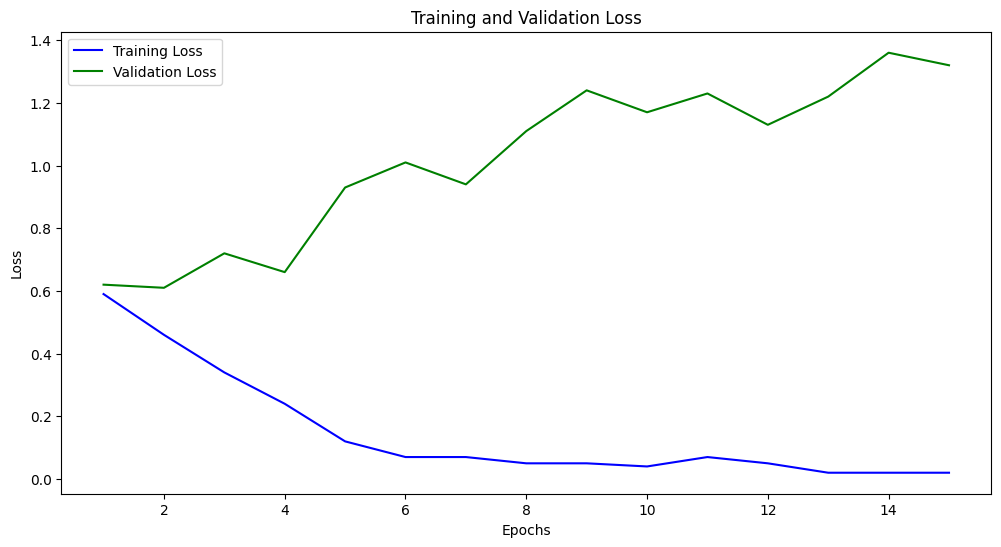

In [13]:
import matplotlib.pyplot as plt

# Example lists of training and validation loss values at different epochs
train_loss = [0.59, 0.46, 0.34, 0.24, 0.12, 0.07, 0.07, 0.05, 0.05,0.04,0.07,0.05,0.02,0.02,0.02]  # Replace with your actual loss values
val_loss = [0.62, 0.61, 0.72, 0.66, 0.93, 1.01,0.94,1.11,1.24,1.17,1.23,1.13,1.22,1.36,1.32]  # Replace with your actual loss values

# Create a list of epochs (x-axis values)
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# training and validation accuracy graph

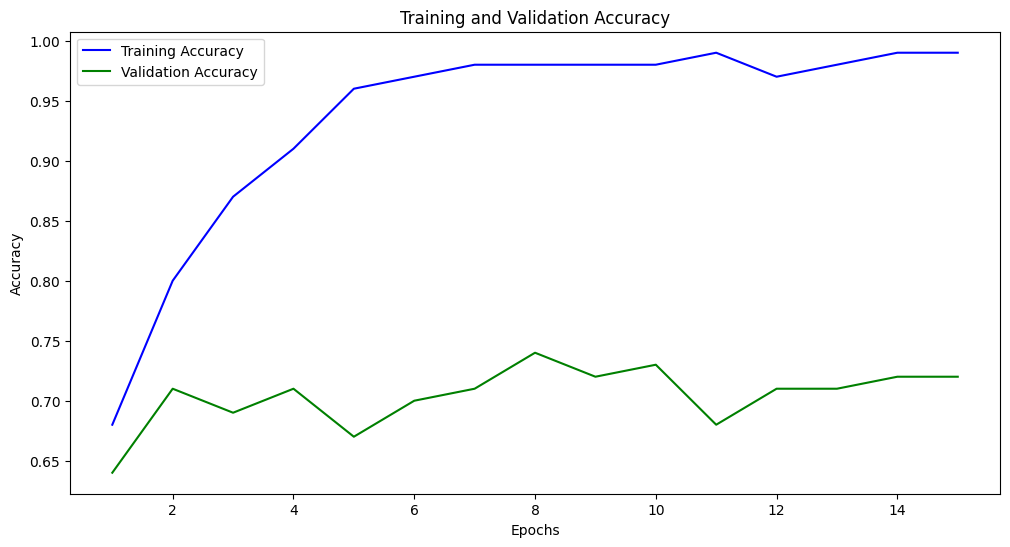

In [14]:
import matplotlib.pyplot as plt

# Example lists of training and validation accuracy values at different epochs
train_accuracy = [0.68, 0.80, 0.87, 0.91, 0.96,0.97,0.98,0.98,0.98,0.98,0.99,0.97,0.98,0.99,0.99]  # Replace with your actual accuracy values
val_accuracy = [0.64, 0.71, 0.69, 0.71, 0.67,0.70,0.71,0.74,0.72,0.73,0.68,0.71,0.71,0.72,0.72]  # Replace with your actual accuracy values

# Create a list of epochs (x-axis values)
epochs = range(1, len(train_accuracy) + 1)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# save the trained model and load the model

In [15]:
# Save the trained model
model.save_pretrained('language_matching_model')


from transformers import BertTokenizer, BertForSequenceClassification

# Load the saved model
model = BertForSequenceClassification.from_pretrained('language_matching_model')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # You need the tokenizer too


# Testing

In [16]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the saved model
loaded_model = BertForSequenceClassification.from_pretrained('language_matching_model')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load your dataset
df = pd.read_csv('/kaggle/input/ielts-writing-dataset10/ielts_writing_dataset.csv')

# Define the user's answer
user_answer = """Between 1995 and 2010, a study was conducted representing the percentages of people born in Australia, versus people born outside Australia, living in urban, rural, and town. First, in 1995, cities represented the major percentage of habitat by roughly 50 percent, followed by rural areas and towns came in last, among people born in Australia. On the other hand, people born outside Australia, cities showed the most percentages of 6o percent, followed by rural areas and towns. In 2010, among people born in Australia, cities had an increase more than 20 percent increase in the total representation and a major decrease in towns and rural areas. Conversely, people born outside Australia, cities had the most percentage among both studies, followed by rural areas and towns."""
# Define the question ID you want to evaluate
question_id = 1  # Change this to the specific question ID you want to evaluate

# Get the reference answer (essay) from the dataset for the specific question
reference_answer = df.loc[df['Task_Type'] == question_id, 'Essay'].iloc[0]

# Preprocess and tokenize the user's answer and reference answer
user_answer = user_answer.lower()  # Lowercase the answer
user_answer = re.sub(r'[^\w\s]', '', user_answer)  # Remove punctuation
reference_answer = reference_answer.lower()  # Lowercase the reference answer
reference_answer = re.sub(r'[^\w\s]', '', reference_answer)  # Remove punctuation

# Calculate the cosine similarity between the user's answer and reference answer
vectorizer = CountVectorizer().fit_transform([user_answer, reference_answer])
vectors = vectorizer.toarray()
cosine_sim = cosine_similarity(vectors)

# Define a threshold for matching rate percentage
threshold = 65  # You can adjust this threshold as needed

# Get the matching rate as a percentage
matching_rate = cosine_sim[0][1] * 100

# Determine if the user's answer matches the reference answer and print the result
if matching_rate >= threshold:
    result = "Match"
else:
    result = "Not Matched"

print(f"Result: {result}")
print(f"Matching Rate: {matching_rate:.2f}%")


Result: Match
Matching Rate: 100.00%


In [17]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the saved model
loaded_model = BertForSequenceClassification.from_pretrained('language_matching_model')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load your dataset
df = pd.read_csv('/kaggle/input/ielts-writing-dataset10/ielts_writing_dataset.csv')

# Define the user's answer
user_answer =  """The methodology for this pioneering assessment approach commences with the administration of
a comprehensive questionnaire, meticulously designed to gauge proficiency in English grammar,
vocabulary, and comprehension. Employing natural language processing (NLP), the system
conducts an in-depth analysis of user responses, establishing a dependable baseline evaluation of
their linguistic competence. Successful completion of this initial phase grants access to the
subsequent spoken test segment."""
# Define the question ID you want to evaluate
question_id = 1  # Change this to the specific question ID you want to evaluate

# Get the reference answer (essay) from the dataset for the specific question
reference_answer = df.loc[df['Task_Type'] == question_id, 'Essay'].iloc[0]

# Preprocess and tokenize the user's answer and reference answer
user_answer = user_answer.lower()  # Lowercase the answer
user_answer = re.sub(r'[^\w\s]', '', user_answer)  # Remove punctuation
reference_answer = reference_answer.lower()  # Lowercase the reference answer
reference_answer = re.sub(r'[^\w\s]', '', reference_answer)  # Remove punctuation

# Calculate the cosine similarity between the user's answer and reference answer
vectorizer = CountVectorizer().fit_transform([user_answer, reference_answer])
vectors = vectorizer.toarray()
cosine_sim = cosine_similarity(vectors)

# Define a threshold for matching rate percentage
threshold = 65  # You can adjust this threshold as needed

# Get the matching rate as a percentage
matching_rate = cosine_sim[0][1] * 100

# Determine if the user's answer matches the reference answer and print the result
if matching_rate >= threshold:
    result = "Match"
else:
    result = "Not Matched"

print(f"Result: {result}")
print(f"Matching Rate: {matching_rate:.2f}%")


Result: Not Matched
Matching Rate: 25.89%


In [18]:
# List the columns in your dataset
columns = df.columns
print("Columns in the dataset:", columns)


Columns in the dataset: Index(['Task_Type', 'Question', 'Essay', 'Examiner_Commen', 'Task_Response',
       'Coherence_Cohesion', 'Lexical_Resource', 'Range_Accuracy', 'Overall'],
      dtype='object')
